In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

if torch.cuda.is_available(): # GPU 이용 가능하다면,

  device = torch.device("cuda")   # 파이토치에게 GPU("cuda") 사용하라고 말해

  print("There are %d GPU(s) available." % torch.cuda.device_count())
  print("We will use the GPU:", torch.cuda.get_device_name(0))  # GPU 장치 이름 출력

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")    # GPU가 없다면/GPU를 이용할 수 없다면 파이토치에게 CPU("cpu") 사용하라고 말해줘

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
import pandas as pd # tsv파일 열기 위한 라이브러리

# Train(훈련) / Dev(검증) / Test(테스트) dataset
dataset_train = pd.read_csv("/content/drive/MyDrive/NLP/NIKL_CoLA_train.tsv", delimiter = '\t', header=None, names = ['sentence_source_train', 'label_train', 'label_notes', 'sentence_train'])
dataset_dev = pd.read_csv("/content/drive/MyDrive/NLP/NIKL_CoLA_dev.tsv", delimiter = '\t', header = None, names = ['sentence_source_dev', 'label_dev', 'lable_notes_dev', 'sentence_dev'])
dataset_test = pd.read_csv("/content/drive/MyDrive/NLP/NIKL_CoLA_test.tsv", delimiter = '\t', header = None, names = ['index', 'sentence_test'])

# 문장 개수 확인
print("Number of training sentence: {:,}\n".format(dataset_train.shape[0]))
print("Number of dev sentence: {:,}\n".format(dataset_dev.shape[0]))
print("Number of test sentence: {:,}\n".format(dataset_test.shape[0]))

# 랜덤으로 10개 문장 확인
# dataset_train.sample(10)
# dataset_dev.sample(10)
# dataset_test.sample(10)

Number of training sentence: 15,877

Number of dev sentence: 2,033

Number of test sentence: 1,061



### dataset_train & dataset_dev 테이블 전처리

In [ ]:
# 데이터 전처리
import numpy as np

# Train 데이터 list화
sentences_train = dataset_train.sentence_train.values
labels_train = dataset_train.label_train.values
sentences_train = sentences_train[1:]
labels_train = labels_train[1:]
labels_train = labels_train.astype(np.int64) # 라벨 정수화
print("Train_sentences: ", sentences_train)
print("Train_labels: ", labels_train)

# Dev 데이터 list화
sentences_dev = dataset_dev.sentence_dev.values
labels_dev = dataset_dev.label_dev.values
sentences_dev = sentences_dev[1:]
labels_dev = labels_dev[1:]
labels_dev = labels_dev.astype(np.int64) # 라벨 정수화
print("Dev_sentences: ", sentences_dev)
print("Dev_labels: ", labels_dev)

# Test 데이터 list화
sentences_test = dataset_test.sentence_test.values
index_test = dataset_test.index.values
sentences_test = sentences_test[1:]
index_test = index_test[1:]
index_test = index_test.astype(np.int64) # 라벨 정수화
print("Test_sentences: ", sentences_test)
print("Test_index: ", index_test)

# Train / Dev / Test 데이터 셋 list화
dataset_train = dataset_train.values[1:]
dataset_dev = dataset_dev.values[1:]
dataset_test = dataset_test.values[1:]

print(dataset_train)
print(dataset_dev)
print(dataset_test)

Train_sentences:  ['높은 달이 떴다.' '달이 뜸이 높았다.' '실없는 사람이 까불까불한다.' ...
 '선생님이 순희에게 책을 읽게 하시나 순희는 책을 읽지 않는다.' '선생님이 순희에게 책을 읽히시나 순희는 책을 읽지 않는다'
 '그의 부주의로 말미암아 사건이 터졌다.']
Train_labels:  [1 0 1 ... 1 0 1]
Dev_sentences:  ['실없는 사람이 까불한다.' '순희에게는 아무리 좋은 옷도 어울리지 않는다.' '사람은 언제나 젊는 수는 없다.' ...
 '밤새 그 술을 다 먹었는 것이다.' '학교에서 철수는 놀았고, 순이는 공부했다.' '그의 부주의에 말미암아 사건이 터졌다.']
Dev_labels:  [0 1 0 ... 0 1 0]
Test_sentences:  ['나는 철수에게 공을 던져다 주었다.' '먹은 것을 다 소화시켜야 한다.' '그가 노래를 부르고는 내가 피아노를 쳤다.' ...
 '그는 나를 바보 여긴다.' '수호는 모든 일에 전혀 무감각하다.' '나는 할아버지가 제일 무서우시다.']
Test_index:  [   1    2    3 ... 1058 1059 1060]
[['T00001' '1' nan '높은 달이 떴다.']
 ['T00001' '0' '*' '달이 뜸이 높았다.']
 ['T00002' '1' nan '실없는 사람이 까불까불한다.']
 ...
 ['T09999' '1' nan '선생님이 순희에게 책을 읽게 하시나 순희는 책을 읽지 않는다.']
 ['T09999' '0' '*' '선생님이 순희에게 책을 읽히시나 순희는 책을 읽지 않는다']
 ['T10000' '1' nan '그의 부주의로 말미암아 사건이 터졌다.']]
[['T00002' '0' '*' '실없는 사람이 까불한다.']
 ['T00029' '1' nan '순희에게는 아무리 좋은 옷도 어울리지 않는다.']
 ['T00033' '0' '*' '사람은 언제나 젊는 수는 없다.']
 ...
 ['T09994' '0' '*' '밤

### SKT-Kobert 인스톨

In [ ]:
!pip install kobert-transformers
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

from transformers import BertTokenizer

#KoBert
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-6a24llxm/kobert-tokenizer_4f89239d73014639b9940ca4e238d397
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-6a24llxm/kobert-tokenizer_4f89239d73014639b9940ca4e238d397


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


### 데이터 토크나이저

In [ ]:
print("Train_Original: ", sentences_train[0])
print("Train_Tokenized: ", tokenizer.tokenize(sentences_train[0]))
print("Train_Token IDs: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_train[0])))

print("Dev_Original: ", sentences_dev[0])
print("Dev_Tokenized: ", tokenizer.tokenize(sentences_dev[0]))
print("Dev_Token IDs: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_dev[0])))

Train_Original:  높은 달이 떴다.
Train_Tokenized:  ['▁높은', '▁달', '이', '▁', '떴', '다', '.']
Train_Token IDs:  [1520, 1597, 7096, 517, 5974, 5782, 54]
Dev_Original:  실없는 사람이 까불한다.
Dev_Tokenized:  ['▁실', '없는', '▁사람이', '▁', '까', '불', '한다', '.']
Dev_Token IDs:  [3036, 6882, 2589, 517, 5591, 6424, 7831, 54]


dataset_train의 encoded_dict

dataset_dev의 encoded_dict

In [ ]:
# Train_data_Tokenize
# 모든 문장을 토크나이즈 한 후 토큰들을 그것들의 단어 ID에 대응·매치시키는 작업

input_ids_train = []
attention_masks_train = []

# 모든 문장에 대하여
for sent in sentences_train:
    # `encode_plus`는:
    #   (1) 문장을 토크나이저.
    #   (2) [CLS]를 모든 문장의 가장 앞에 삽입.
    #   (3) [SEP]을 모든 문장의 가장 뒤에 삽입.
    #       CLS, SEP는 토큰 임베딩 분야의 특수 토큰으로,
    #       CLS는 special CLaSsification token, SEP은 sepcial SEParator token을 의미
    #   (4) 토큰들을 그들의 단어 아이디와 매치시킴.
    #   (5) 문장의 길이는 'max_length' 수치에 맞게 늘려주거나 줄여줌.
    #       Pad: 특정 형상의 배열로 변형할 때 빈자리를 0으로 채워준다는 의미
    #   (6) [PAD] 토큰을 위한 attention mask 생성
    encoded_dict = tokenizer.encode_plus(
                        sent,                         # 인코딩할 문장 자리 / 문장을 인코딩
                        add_special_tokens = True,    # 특수 토큰 [CLS]와 [SEP] 추가
                        max_length = 64,              # max_length에 맞게 모든 문장 패딩 & 축소
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True, # Attention Mask 구축 / 자료 구조는 tensor 형태
                                                      # Attention Mask는 단어 배치와 동일하게 "1" 생성 
                        return_tensors = 'pt',        # 인코딩된 문장을 pytorch 텐서 형태로 변경
                                                      # tensorflow를 사용하고 있다면 return_tensors = 'tf'라고 씀
                   )

    # 인코딩된 문장들 List[input_ids_train]에 넣기 but input_ids_train은 이미
    input_ids_train.append(encoded_dict['input_ids'])
    
    # Attention mask 인자들 List[attention_masks_train]에 넣기 (simply differentiates padding from non-padding).
    attention_masks_train.append(encoded_dict['attention_mask'])

input_ids_train = torch.cat(input_ids_train, dim=0) # dim은 축·차원의 수 axis0부터 시작, dim=0는 축 1개 or 1차원
attention_masks_train = torch.cat(attention_masks_train, dim=0)
# print("Train_labels_array: ", labels_train)
labels_train = torch.tensor(labels_train)


# Train 데이터의 문장과 ID 출력. (인코딩이 잘 됐는지 확인하는 작업)
print('Train_Original: ', sentences_train[0]) # 1차원
print('Train_Token IDs: {}, \nTrain_input_ids_shape: {}, \nTrain_input_ids_dim: {}'.format(input_ids_train, input_ids_train.shape, input_ids_train.ndim))
print('Train_labels: {}, \nTrain_labels_shape: {}, \nTrain_labels_dim: {}'.format(labels_train, labels_train.shape, labels_train.ndim))

# Dev_data_Tokenize
# 모든 문장을 토크나이즈 한 후 토큰들을 그것들의 단어 ID에 대응·매치시키는 작업
input_ids_dev = []
attention_masks_dev = []

# 위와 동일하게 모든 문장에 encode_plus 적용
for sent in sentences_dev:
    encoded_dict = tokenizer.encode_plus(
                        sent, 
                        add_special_tokens = True,
                        max_length = 64,
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        )
    
    # encode_dict로 인코딩된 문장을 input_ids_dev 리스트에 추가   
    input_ids_dev.append(encoded_dict['input_ids'])
    
    # econde_dict의 어텐션마스크를 attention mask_dev 리스트에 추가 (simply differentiates padding from non-padding).
    attention_masks_dev.append(encoded_dict['attention_mask'])
    
# 리스트를 텐서 형태로 변경
input_ids_dev = torch.cat(input_ids_dev, dim=0)
attention_masks_dev = torch.cat(attention_masks_dev, dim=0)
labels_dev = torch.tensor(labels_dev)

# 0번째 문장, 토큰, 라벨 아이디 출력
print('Dev_Original: ', sentences_dev[0]) # 1차원
print('Dev_Token IDs: {}, \nDev_input_ids_shape: {}, \nDev_input_ids_dim: {}'.format(input_ids_dev[0], input_ids_dev.shape, input_ids_dev.ndim))
print('Dev_labels: {}, \nDev_labels_shape: {}, \nDev_labels_dim: {}'.format(labels_dev, labels_dev.shape, labels_dev.ndim))

NameError: ignored

In [ ]:
from torch.utils.data import TensorDataset, random_split

# TensorDataset()은 텐서를 감싸는 (wrapping) Dataset으로, 길이와 인덱싱 방식을 정의
# Dataset을 상속한 클래스로, 학습데이터·독립변수X(input_ids_train, attention_mask_train)와 레이블·종속변수Y(labels_train)를 묶어 놓는 컨테이너
# TensorDataset()을 DataLoader에 전달하면, 반복문(for문)에서 데이터의 일부분만 간단히 추출할 수 있다.
# TensorDataset()은 텐서만 전달 가능하며, Variable은 전달 불가.
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dev_dataset = TensorDataset(input_ids_dev, attention_masks_dev, labels_dev)

# print(train_dataset[input_ids_train]) 

# 각 세트의 샘플 문장 개수 확인 및 train_size/dev_size 변수에 저장
print(len(train_dataset))
print(len(dev_dataset))
train_size = int(len(train_dataset))
dev_size = int(len(dev_dataset))

# 트레이닝 데이터 & 검증 데이터 크기 다시 한 번 확인
print("Number of train sentence: {:,}".format(train_size))
print("Number of dev sentence: {:,}".format(dev_size))


15876
2032
Number of train sentence: 15,876
Number of dev sentence: 2,032


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# DataLoader는 데이터를 학습시키기 위해 batch size를 알아야 하기 때문에, batch size를 설정해줄 것.
# Fine-tuning BERT를 만들기 위해, batch size를 16 또는 32을 추천
batch_size = 32

# Train Dataloader 생성
train_dataloader = DataLoader(
              train_dataset, # Train samples.
              sampler = RandomSampler(train_dataset),
              batch_size = batch_size)

# Dev Dataloader 생성
dev_dataloader = DataLoader(
              dev_dataset, # Dev samples.
              sampler = RandomSampler(dev_dataset),
              batch_size = batch_size)

print(len(train_dataloader))
print(len(dev_dataloader))

497
64


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# BertForSequenceClassification 설치
# 가장 위 레이어에 단일 linear classification 레이어를 가진, 사전 학습된 BERT 모델
model = BertForSequenceClassification.from_pretrained(
    'skt/kobert-base-v1',
    num_labels = 2, # 레이블의 개수는 2진분류가 디폴트.
                    # 하지만 멀티 클래스 태스크를 증가시킬 수 있다(?)
    output_attentions = False,
    output_hidden_states = False,
)

# Pytorch에게 이 모델을 GPU에서 사용하라고 요청
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at skt/kobert-base-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [ ]:
# 튜플들의 리스트 형태로 모델의 모든 파라미터들 추출

params = list(model.named_parameters())
print('The BERT model has {:} different named paraeters.\n'.format(len(params)))

print('===== Embedding Layer =====\n')

for p in params [0:5]:
  print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params [5:21]:
  print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params [-4:]:
  print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named paraeters.

===== Embedding Layer =====

bert.embeddings.word_embeddings.weight                   (8002, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [ ]:
# 참고: AdamW은 huggingface 라이브러리에 있는 클래스. (PyTorch와 대조적으로)
# 아마도 W는 "Weight Decay fix"를 의미하는 것으로 추정
optimizer = AdamW(model.parameters(),
                  lr=2e-5,   # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                  )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# 학습 epochs 설정. 글쓴이는 2~4 추천
# 일단 4로 해보고, 오버 피팅되면 조절
epochs = 4

# 학습 횟수·단계 설정: [batch의 개수] x [epochs의 개수]. (batch size ≠ batch의 개수)
# ※학습 샘플 수와 같지 않음
total_steps = len(train_dataloader) * epochs

# Learning Rate 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# 예측 대비 레이블의 정확성 계산을 위한 함수
def flat_accuracy(preds, labels):
  # pred_flat = torch.argmax(preds, axis=0).flatten()
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
  '''
  Takes a time in seconds and returns a string hh:mm:ss
  '''
  # 1초 단위로 반올림
  elapsed_rounded = int(round((elapsed))) 

  # 시간형태: hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

### Dev_data_Tokenize


In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible. 하지만 42는 큰 의미 없는 수
seed_val = 42

random.seed(seed_val) # 생성된 난수 중 씨드값 42의 수 출력(고정)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 학습값 손실, 검증값 손실, 검증데이터 정확성, 시간 등 여러 측정 상태 저장 및 출력
training_stats = []

# 전체 학습 시간 측정
total_t0 = time.time()

# 매 epoch에 대해서...
for epoch_i in range(0, epochs): # ∵epochs = 4
    
    # ========================================
    #               Training
    # ========================================
    
    # 학습 데이터셋에 대한 1회차 실행

    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # epoch 도는데 걸리는 시간 측정
    t0 = time.time()

    # 1 epoch에 대한 총 학습값 손실 0으로 리셋
    total_train_loss = 0

    # 모델(model = BertForSequenceClassification.from_pretrained)을 트레이닝 모드에 넣음.
    # Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        
        # print("step: {}, batch: {}".format(step, batch))

        # 40 배치씩 결과 출력
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Train_dataloader의 트레이닝 batch 해체 분석. 
        # batch를 해체시킬 때, 각 tensor를 'to' 메소드를 사용하는 GPU(device = torch.device("cuda"))에 복사
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # b_input_ids: 2차원, b_labels: 1차원

        # 항상 이전에 계산된 gradients들은, backward pass를 수행하기 전에 초기화하여 0으로 만들어 줘야함
        # PyTorch는 이것을 자동으로 해주지 않음.
        # 왜냐하면 RNNs을 학습시키는 동안에 gradients를 계산하는 것이 편리하기 때문에 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # 전방 전달(forward pass) 수행 (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.

        '''
        전방 전달(forward pass)은 입력부터 출력까지 값을 계산한다.
        그리고 나서 후방 전달(backward pass)은 역전파(back propagation)을 수행하는데, 
        이는 끝에서 시작해서 반복적으로 연쇄 법칙을 적용해 회로 입력에 대한 모든 길에서
        그라디언트 값을 계산한다. 그라디언트 값은 회로를 통해 거꾸로 흐르는 것으로 볼 수 있다.

        순전파(forwards propagation)은 뉴럴 네트워크의 그래프를 계산하기 위해서
        중간 변수들을 순서대로 계산하고 저장한다. 즉, 입력층부터 시작해서 출력층까지 처리한다.
        역전파(back propagation)은 중간 변수와 파라미터에 대한 그래디언트(gradient)를
        반대 방향으로 계산하고 저장한다.
        '''

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        loss = outputs[0]
        loss = loss.float()
        # print("loss:", loss) # loss값 확인

        # 모든 batch에 대한 학습 손실값을 축적
        # 그래서 우리는 마지막에 평균 손실값을 구할 수 있다.
        # 'loss'는 단일 값을 포함한 Tensor. 
        # '.item()'함수는 tensor로부터 Python 값을 리턴.
        total_train_loss += loss.item()

        # gradients를 계산하기 위해 loss에 대해 후방 전달(backward pass) 수행
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Development
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Development...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    predictions , true_labels = [], []

    # Evaluate data for one epoch
    for batch in dev_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            logits = outputs[0]
            logits = logits.float()

        # Accumulate the development loss.
        total_eval_loss += logits.item()

        dev_logits = outputs[1]
        # dev_logits: 2차원, b_labels: 1차원

        # (log_)softmax 함수는 tensor 형태로 들어가야함
        # dev_logits = F.log_softmax(dev_logits, dim=1)
        # print("DIM_dev_logits: {}, dev_logits: {}".format(dev_logits.ndim, dev_logits))

        # Move logits and labels to CPU
        # argmax 함수는 numpy 형태로 들어가야함
        dev_logits = dev_logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(dev_logits, label_ids)

    # Report the final accuracy for this development run.
    avg_dev_accuracy = total_eval_accuracy / len(dev_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_dev_accuracy))

    # Calculate the average loss over all of the batches.
    avg_dev_loss = total_eval_loss / len(dev_dataloader)
    
    # Measure how long the validation run took.
    development_time = format_time(time.time() - t0)
    
    print("  Development Loss: {0:.2f}".format(avg_dev_loss))
    print("  Development took: {:}".format(development_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Dev. Loss': avg_dev_loss,
            'Dev. Accur.': avg_dev_accuracy,
            'Training Time': training_time,
            'Development Time': development_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    497.    Elapsed: 0:00:26.
  Batch    80  of    497.    Elapsed: 0:00:53.
  Batch   120  of    497.    Elapsed: 0:01:19.
  Batch   160  of    497.    Elapsed: 0:01:46.
  Batch   200  of    497.    Elapsed: 0:02:13.
  Batch   240  of    497.    Elapsed: 0:02:40.
  Batch   280  of    497.    Elapsed: 0:03:06.
  Batch   320  of    497.    Elapsed: 0:03:33.
  Batch   360  of    497.    Elapsed: 0:04:00.
  Batch   400  of    497.    Elapsed: 0:04:27.
  Batch   440  of    497.    Elapsed: 0:04:53.
  Batch   480  of    497.    Elapsed: 0:05:20.

  Average training loss: 0.68
  Training epoch took: 0:05:31

Running Development...
  Accuracy: 0.62
  Development Loss: 0.64
  Development took: 0:00:14

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    497.    Elapsed: 0:00:27.
  Batch    80  of    497.    Elapsed: 0:00:53.
  Batch   120  of    497.    Elapsed: 0:01:20.
  Batch   160  of    497.    Elapsed: 0:01:47.
  Batc

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Dev. Loss,Dev. Accur.,Training Time,Development Time
epoch,,,,,
1,0.68,0.64,0.62,0:05:31,0:00:14
2,0.60,0.64,0.65,0:05:31,0:00:14
3,0.51,0.68,0.65,0:05:32,0:00:14
4,0.43,0.75,0.66,0:05:32,0:00:14


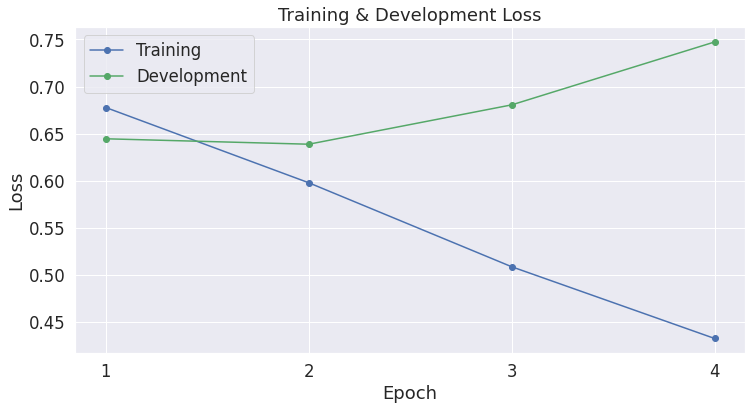

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# seaborn 사용하여 plot 생성
sns.set(style='darkgrid')

# plot 사이즈 & 폰트 사이즈 지정
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Dev. Loss'], 'g-o', label="Development")

# Label the plot.
plt.title("Training & Development Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Test 데이터 검증


In [ ]:
# import pandas as pd

# # Load the dataset into a pandas dataframe.

# # Test 데이터 셋 array화
# dataset_dev = pd.read_csv("/content/drive/MyDrive/NLP/NIKL_CoLA_dev.tsv", delimiter = '\t', header = None, names = ['sentence_source_dev', 'label_dev', 'lable_notes_dev', 'sentence_dev'])
# print(dataset_dev)

# # 문장 개수 확인
# print('Number of test sentences: {:,}\n'.format(dataset_dev.shape[0]))

# # Create sentence and lists
# sentences_dev = dataset_dev.sentence_dev.values
# sentences_dev = sentences_dev[1:]
# labels_dev = dataset_dev.label_dev.values
# labels_dev = labels_dev[1:]
# labels_dev = labels_dev.astype(np.int64) # 라벨 정수화
# print(sentences_dev)


# # Tokenize all of the sentences and map the tokens to thier word IDs.
# input_ids_dev = []
# attention_masks_dev = []

# # For every sentence...
# for sent in sentences_dev:
#     # `encode_plus` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     #   (5) Pad or truncate the sentence to `max_length`
#     #   (6) Create attention masks for [PAD] tokens.
#     encoded_dict = tokenizer.encode_plus(
#                         sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = 64,           # Pad & truncate all sentences.
#                         padding = 'max_length',
#                         truncation = True,
#                         return_attention_mask = True,   # Construct attn. masks.
#                         return_tensors = 'pt',     # Return pytorch tensors.
#                    )
    
#     # Add the encoded sentence to the list.    
#     input_ids_dev.append(encoded_dict['input_ids'])
    
#     # And its attention mask (simply differentiates padding from non-padding).
#     attention_masks_dev.append(encoded_dict['attention_mask'])

# # Convert the lists into tensors.
# input_ids_dev = torch.cat(input_ids_dev, dim=0)
# attention_masks_dev = torch.cat(attention_masks_dev, dim=0)
# labels_dev = torch.Tensor(labels_dev)

# print('Dev_Original: ', sentences_dev[0]) # 1차원
# print('Dev_Token IDs: {}, \nDev_input_ids_shape: {}, \nDev_input_ids_dim: {}'.format(input_ids_dev[0], input_ids_dev.shape, input_ids_dev.ndim))
# print('Dev_labels: {}, \nDev_labels_shape: {}, \nDev_labels_dim: {}'.format(labels_dev, labels_dev.shape, labels_dev.ndim))

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids_dev, attention_masks_dev, labels_dev)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} dev sentences...'.format(len(input_ids_dev)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids,
                      token_type_ids=None, 
                      attention_mask=b_input_mask)

  dev_logits = outputs[0]
  # print("dev_logits: ", dev_logits)
  # dev_preds = torch.argmax(torch.nn.functional.log_softmax(dev_logits,dim=1), dim=1)

  # Move logits and labels to CPU
  dev_logits = dev_logits.to('cpu').numpy()
  label_ids = b_labels.to('cpu').numpy().astype(np.int64)
  dev_logits = dev_logits.tolist()
  label_ids = label_ids.tolist()
  
  # Store predictions and true labels
  predictions.append(dev_logits)
  true_labels.append(label_ids)


print("Predictions: ", predictions)
print("True_labels: ", true_labels)

print('    DONE.')

Predicting labels for 2,032 dev sentences...
Predictions:  [[[-1.4599076509475708, 0.990625262260437], [-1.2279213666915894, 0.8192576766014099], [1.4068405628204346, -1.387860894203186], [-1.6817760467529297, 1.1786209344863892], [-1.1707144975662231, 0.7168563008308411], [1.2575523853302002, -1.1231592893600464], [-0.22775517404079437, -0.16848061978816986], [-1.0576753616333008, 0.6426922082901001], [-1.627734661102295, 1.1230442523956299], [0.5537183284759521, -0.9803716540336609], [0.7563073635101318, -0.9292792081832886], [-1.8366167545318604, 1.34181809425354], [-0.9090119004249573, 0.37342309951782227], [-0.8226344585418701, 0.23106776177883148], [-0.6003010869026184, 0.10473090410232544], [1.3681544065475464, -1.0044609308242798], [-0.6188574433326721, 0.06222949177026749], [0.6464830040931702, -1.0633933544158936], [-0.26846787333488464, -0.25151708722114563], [0.2632990777492523, -0.6695963740348816], [-0.2617894113063812, 0.3484037518501282], [1.3801348209381104, -0.9383382

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (labels_dev.sum(), len(labels_dev), (labels_dev.sum() / len(labels_dev) * 100.0)))

Positive samples: 1071 of 2032 (52.71%)


In [ ]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')
print("Len_true_labels: ", len(true_labels))

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  print(pred_labels_i)
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...
Len:  64
[1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0]
[0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1]
[0 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0]
[0 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1]
[1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1]
[0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1]
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0 0]
[1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1]
[1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0]
[1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0]
[1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1]
[1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0]
[0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0 0]
[1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1]
[0 0 0 1 1 1 1 1

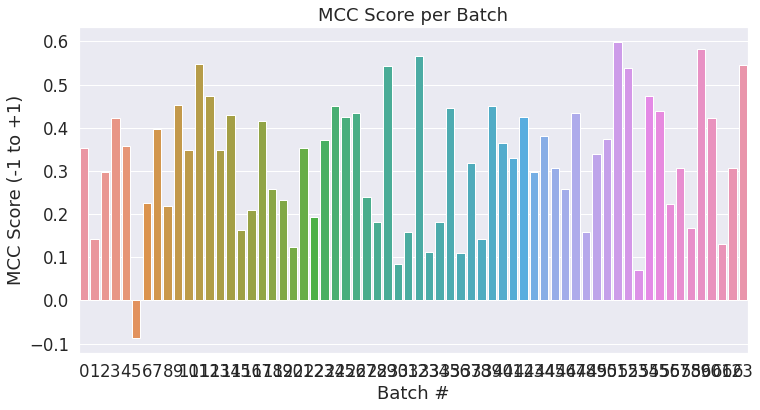

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.315


In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/spiece.model',
 './model_save/added_tokens.json')

In [ ]:
!pip install transformers
from transformers import BertForSequenceClassification

# output_dir = '/content/drive/My Drive/saved_model/KoBERT_model_1'
output_dir = './model_save/'

print(output_dir)

./model_save/


In [ ]:
from transformers import BertTokenizer
from kobert_tokenizer import KoBERTTokenizer
import torch
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')

tokenizer = KoBERTTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

Loading BERT tokenizer...


In [ ]:
input_ids_test = []
attention_masks_test = []

print("sentences_test:", sentences_test)
# 모든 문장에 대하여
for sent in sentences_test:
    # `encode_plus` will:
    #   (1) 문장을 토크나이저 합니다. Tokenize the sentence.
    #   (2) [CLS]를 모든 문장의 가장 앞에 삽입합니다.
    #   (3) [SEP]을 모든 문장의 가장 뒤에 삽입합니다.
    #       CLS, SEP는 토큰 임베딩 분야의 특수 토큰으로,
    #       CLS는 special CLaSsification token, SEP은 sepcial SEParator token을 의미
    #   (4) 토큰들을 그들의 단어 아이디와 매치시킵니다.
    #   (5) 문장의 길이는 'max_length' 수치에 맞게 늘려주거나 줄여줍니다.
    #       Pad: 특정 형상의 배열로 변형할 때 빈자리를 0으로 채워준다는 의미
    #   (6) [PAD] 토큰을 위한 attention mask 생성
    encoded_dict = tokenizer.encode_plus(
                        sent,                         # 인코딩할 문장 자리 / 문장을 인코딩
                        add_special_tokens = True,    # 특수 토큰 [CLS]와 [SEP] 추가
                        max_length = 64,              # max_length에 맞게 모든 문장 패딩 & 축소
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True, # Attention Mask 구축 / 자료 구조는 tensor 형태
                                                      # Attention Mask는 단어 배치와 동일하게 "1" 생성 
                        return_tensors = 'pt',        # 인코딩된 문장을 pytorch 텐서 형태로 변경
                                                      # tensorflow를 사용하고 있다면 return_tensors = 'tf'라고 씀
                   )

    # 인코딩된 문장들 List[input_ids_test]에 넣기 but input_ids_test은 이미
    input_ids_test.append(encoded_dict['input_ids'])
    attention_masks_test.append(encoded_dict['attention_mask'])

input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
index_test = torch.tensor(index_test)

print("Input_id_test: ", input_ids_test)
print("Attention_mask_test: ", attention_masks_test)
print("Index_test: ", index_test)

sentences_test: ['나는 철수에게 공을 던져다 주었다.' '먹은 것을 다 소화시켜야 한다.' '그가 노래를 부르고는 내가 피아노를 쳤다.' ...
 '그는 나를 바보 여긴다.' '수호는 모든 일에 전혀 무감각하다.' '나는 할아버지가 제일 무서우시다.']
Input_id_test:  tensor([[   2, 1375, 4473,  ...,    1,    1,    1],
        [   2, 2010, 7086,  ...,    1,    1,    1],
        [   2, 1186, 1479,  ...,    1,    1,    1],
        ...,
        [   2, 1191, 1370,  ...,    1,    1,    1],
        [   2, 2872, 7926,  ...,    1,    1,    1],
        [   2, 1375, 4977,  ...,    1,    1,    1]])
Attention_mask_test:  tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Index_test:  tensor([   1,    2,    3,  ..., 1058, 1059, 1060])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded = model_loaded.to(device)
input_ids_test = input_ids_test.to(device)
attention_masks_test = attention_masks_test.to(device)

In [ ]:
with torch.no_grad():
  # Forward pass, calculate logit predictions
  outputs = model_loaded(input_ids_test, token_type_ids=None, attention_mask=attention_masks_test)
test_logits = outputs[0]
test_logits = test_logits.detach().cpu().numpy()
test_logits = np.argmax(test_logits, axis=1).flatten()
labels_test = []
for i in range(len(test_logits)):
    index = test_logits[i]
    if index == 1:
      labels_test.append(1)
      # print("1(True)")
    else:
      labels_test.append(0)
      # print("0(False)")
result = labels_test
print(result)

[1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 

In [ ]:
import json

dict_result = [{"idx" : idx, "label" : data} for idx, data in enumerate(result)]
with open("/content/drive/MyDrive/Colab Notebooks/COLA_Test_HJ.json", "w") as json_file:
    json_result = {"cola" : dict_result}
    json.dump(json_result, json_file)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/COLA_Test_HJ.json') as json_file:
    COLA = json.load(json_file)
    print(COLA)

{'cola': [{'idx': 0, 'label': 1}, {'idx': 1, 'label': 1}, {'idx': 2, 'label': 0}, {'idx': 3, 'label': 1}, {'idx': 4, 'label': 0}, {'idx': 5, 'label': 1}, {'idx': 6, 'label': 1}, {'idx': 7, 'label': 1}, {'idx': 8, 'label': 0}, {'idx': 9, 'label': 0}, {'idx': 10, 'label': 1}, {'idx': 11, 'label': 0}, {'idx': 12, 'label': 1}, {'idx': 13, 'label': 1}, {'idx': 14, 'label': 1}, {'idx': 15, 'label': 1}, {'idx': 16, 'label': 0}, {'idx': 17, 'label': 0}, {'idx': 18, 'label': 1}, {'idx': 19, 'label': 0}, {'idx': 20, 'label': 1}, {'idx': 21, 'label': 1}, {'idx': 22, 'label': 1}, {'idx': 23, 'label': 1}, {'idx': 24, 'label': 0}, {'idx': 25, 'label': 1}, {'idx': 26, 'label': 0}, {'idx': 27, 'label': 0}, {'idx': 28, 'label': 0}, {'idx': 29, 'label': 1}, {'idx': 30, 'label': 1}, {'idx': 31, 'label': 0}, {'idx': 32, 'label': 1}, {'idx': 33, 'label': 0}, {'idx': 34, 'label': 0}, {'idx': 35, 'label': 1}, {'idx': 36, 'label': 0}, {'idx': 37, 'label': 1}, {'idx': 38, 'label': 0}, {'idx': 39, 'label': 1}, 